# PREUVE DE CONCEPT

## 1. Préparation des données

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from time import time

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import adjusted_rand_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
import joblib

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3, EfficientNetV2B3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l1
from tensorflow.keras.utils import to_categorical, set_random_seed
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

from pyts.image import GramianAngularField

import os
from PIL import Image

%cd ..
import src.mytools as mt
%cd notebooks

2024-08-20 21:18:48.659418: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-20 21:18:48.659503: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-20 21:18:48.689152: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-20 21:18:48.767335: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-20 21:18:50.297591: W tensorflow/compiler/tf2

/home/chakir/Bureau/PROJETS/Projet7
/home/chakir/Bureau/PROJETS/Projet7/notebooks


/home/chakir/Bureau/PROJETS/Projet7/env/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


Le dataset sur lequel nous allons travailler est le **MIT-BIH Arhythmia Database**. Il s'agit de 109444 ECG de patients d'un hôpital de Boston enregistrés entre 1975 et 1979. Les patients sont des hommes et des femmes âgés entre 23 et 89 ans. Les ECG ont été annotés par au moins deux médecins selon cinq modalités : normal beat (N), supraventricular premature beat (S), premature ventricular contraction (V), fusion of ventricular and normal beat (F) et unclassifiable beat (Q).

Ces séries temporelles ont été plus tard numérisés, mises sous forme tabulaire et normalisés (MinMax). Ici, elles ont déjà été scindées en un dataset d'entraînement et un autre de test. Nous allons commencer par charger et fusionner les deux fichiers, que nous re-scinderons aléatoirement plus tard :

In [2]:
data1 = pd.read_csv('../data/mitbih_train.csv')
data2 = pd.read_csv('../data/mitbih_test.csv')

In [3]:
data1.shape[0] + data2.shape[0]

109444

In [4]:
data1.columns = range(188)
data2.columns = range(188)
data = pd.concat([data1,data2])
data.shape

(109444, 188)

La dernière colonne du dataset correspond à la variable cible, qui est déjà encodée (Label Encoder).

In [5]:
data.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.927461,1.000000,0.626943,0.193437,0.094991,0.072539,0.043178,0.053541,0.093264,0.189983,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
data.iloc[:,187].unique()

array([0., 1., 2., 3., 4.])

L'encodage a été réalisé de la façon suivante :

N : 0 

S : 1

V : 2

F : 3

Q : 4

In [7]:
mt.valeurs_manquantes(data)

,effectif,taux


Il n'y a aucune valeur manquante dans le dataset.

In [8]:
stat = mt.stats_extend(data)[['min','max']]

In [9]:
stat.loc[(stat['min'] != 0) | (stat['max'] != 1), :]

,min,max
187,0.0,4.0


Toutes les colonnes ont bien été normalisées avec le MinMax (La dernière correspond à la variable cible et ne fait pas partie des séries temporelles).

Nous allons maintenant séparer les séries temporelles et la cible :

In [10]:
X = data.loc[:,:186]
y = data[187]
X.shape[1]

187

X est le dataset d'entraînement et y est la variable cible.

## 2. La baseline : une forêt aléatoire

Nous allons maintenant effectué une recherche sur grille avec validation croisée pour trouver la forêt aléatoire optimale. Nous allons optimiser deux hyperparamètres :

- Le nombre d'arbres : Entre 100 et 300, avec un pas de 50.
- La profondeur des arbres : De 2 à 10.

In [11]:
# Fixer les valeurs des hyperparamètres à tester :
param_grid = {'n_estimators': range(100,301,50),
              'max_depth': range(2,11)}

# Choisir le score à optimiser :
score = 'f1_weighted'

# Créer un modèle avec recherche d'hyperparamètres par validation croisée :
model = GridSearchCV(RandomForestClassifier(),          # choix du modèle
                     param_grid,                        # hyperparamètres à tester
                     cv=5,                              # nombre de plis pour la validation croisée
                     scoring=score)                     # score à optimiser

# Optimiser ce modèle sur le jeu d'entraînement :
model.fit(X, y)

# Afficher le(s) hyperparamètre(s) optimaux :
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print(model.best_params_)

/home/chakir/Bureau/PROJETS/Projet7/env/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'max_depth': 10, 'n_estimators': 200}


Le modèle optimal est le modèle à 200 arbres d'une profondeur de 10. Nous allons maintenant scinder aléatoirement l'ensemble des données en un dataset d'entraînement (80%) et un dataset de test (20%) :

In [11]:
# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Entraînons le modèle optimal et calculons ses performances sur les données de test :

In [12]:
model = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, n_estimators=200, random_state=42)

In [13]:
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

La fonction `metrics_display` ci-dessous permet de calculer et d'afficher plusieurs métriques de classification ainsi que la matrice de confusion.

In [12]:
def metrics_display(true_labels, predicted_labels, predicted_probas=None):
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, average='macro')
    recall = recall_score(true_labels, predicted_labels, average='macro')
    f1 = f1_score(true_labels, predicted_labels, average='macro')
    ARI = adjusted_rand_score(true_labels, predicted_labels)
    print(f'accuracy = {accuracy}   precision = {precision}   recall={recall}   f1 = {f1}   ARI = {ARI}')

    if predicted_probas is not None:
        AUC = roc_auc_score(true_labels, predicted_probas, average='macro', multi_class='ovr')
        print(f'AUC-ROC = {AUC}')

    cm = confusion_matrix(true_labels, predicted_labels)
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    disp1 = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['N', 'S', 'V', 'F', 'Q'])
    disp1.plot(cmap='Reds', ax=axes[0], colorbar=False)
    axes[0].set_title('Matrice brute')

    disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_percentage, display_labels=['N', 'S', 'V', 'F', 'Q'])
    disp2.plot(cmap='Blues', ax=axes[1], colorbar=False)
    axes[1].set_title('Matrice en pourcentages')

    plt.tight_layout()
    plt.show()

accuracy = 0.9585636621133903   precision = 0.9681446915137301   recall=0.660062933661351   f1 = 0.7292184394540592   ARI = 0.82230018510984
AUC-ROC = 0.9713433511338068


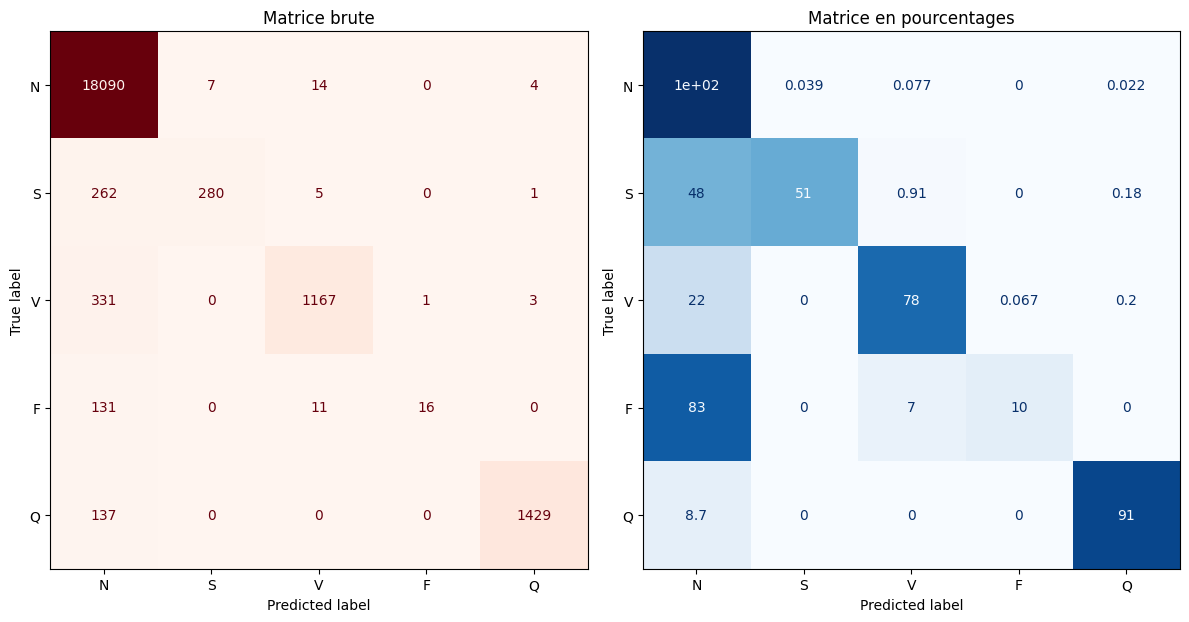

In [21]:
metrics_display(y_test, y_pred, y_pred_proba)

On peut voir que le recall score est insatisfaisant en raison des classes S et F (les deux plus petites classes) qui sont mal voir très mal classées et souvent confondues avec la classe majoritaire N.

On enregistre le modèle localement :

In [22]:
joblib.dump(model, '../models/random_forest_baseline.joblib')

['random_forest_baseline.joblib']

## 3. Transfert learning avec deux CNN : InceptionV3 et EfficientNetV2

### 3.1 Transformation des séries temporelles en images

Pour pouvoir utiliser des modèles de CNN pré-entraîné, il nous faut convertir chaque série temporelle en image. Il y a plusieurs méthodes de transformation et celle que nous allons utilisée est la méthode des champs angulaires de Gram (GAF).

Les séries temporelles vont être transformées en images de taille 100*100 ; c'est la taille maximale que j'ai pu obtenir sans faire planter mon noyau.

In [23]:
# Initialiser GAF avec une taille d'image plus petite
gaf = GramianAngularField(image_size=100, method='summation')

# Transformer les données
X_train_gaf = gaf.fit_transform(X_train)
X_test_gaf = gaf.fit_transform(X_test)

In [24]:
X_train_gaf.shape

(87555, 100, 100)

Nous allons maintenant créer deux dossiers **train_images** et **test_images** dans lesquels nous allons enregistrer les images d'entraînement et de test. Chaque dossier contiendra 5 sous-dossiers correspondant aux 5 catégories de signaux.

In [13]:
train_dir = '../data/train_images'
test_dir = '../data/test_images'

In [ ]:
# Créer des répertoires pour les images d'entraînement et de test
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Créer des répertoires pour chaque classe

for classes in y.unique():
    os.makedirs(os.path.join(train_dir, str(int(classes))), exist_ok=True)
    os.makedirs(os.path.join(test_dir, str(int(classes))), exist_ok=True)

In [26]:
def save_images(images, labels, directory):
    """
    Redimensionner et sauvegarder les images en format JPEG.
    
    Parameters:
    - images : numpy array, tableau des images à sauvegarder.
    - directory : str, répertoire où sauvegarder les images.
    - file_prefix : str, préfixe pour les noms de fichiers.
    """
    
    for i, img in enumerate(images):
        # Normaliser les valeurs flottantes entre 0 et 255 et convertir en uint8
        img_uint8 = (img - img.min()) / (img.max() - img.min()) * 255
        img_uint8 = img_uint8.astype(np.uint8)
        
        # Convertir en image PIL et redimensionner
        img_pil = Image.fromarray(img_uint8)
        img_resized = img_pil.resize((100, 100))
        
        # Sauvegarder l'image
        classe = str(int(labels[i]))
        img_resized.save(os.path.join(f'../data/{directory}/{classe}', f'{classe}_{i}.jpg'))

In [27]:
# Redimensionner et sauvegarder les images pour l'ensemble d'entraînement
save_images(X_train_gaf, y_train.values, train_dir)

# Redimensionner et sauvegarder les images pour l'ensemble de test
save_images(X_test_gaf, y_test.values, test_dir)

### 3.2 Construction des générateurs d'images pour les CNN

Commençons par fixer les germes des générateurs aléatoires pour assurer la reproductibilité des résultats :

In [14]:
# Fixation des sources des générateurs aléatoires pour assurer la reproductibilité des résultats.
seed_value = 42
set_random_seed(seed_value)

Nous allons maintenant construire un générateur d'entraînement et un génrateur de test. Les images d'entraînement seront présentées dans un ordre différent à chaque époque (*shuffle = True*).

In [15]:
# Définition des générateurs de données

generator = ImageDataGenerator(rescale=1./255)

train_generator = generator.flow_from_directory(train_dir,
                                                target_size=(100, 100),
                                                class_mode='categorical',
                                                seed=seed_value
                                                )

test_generator = generator.flow_from_directory(test_dir,
                                               target_size=(100, 100),
                                               class_mode='categorical',
                                               shuffle=False,
                                               seed=seed_value
                                               )

Found 87555 images belonging to 5 classes.
Found 21889 images belonging to 5 classes.


### 3.3 Transfer learning avec InceptionV3

Commençons par charger le modèle de base pré-entraîné sur la base de données *Imagenet*, sans la partie supérieure de classification.

In [29]:
# Charger le modèle InceptionV3 pré-entraîné sans les couches supérieures
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(100, 100, 3))

In [30]:
n = len(base_model.layers)
n

311

Le modèle contient 311 couches. Nous allons toutes les geler à l'exception des 20 dernières que nous allons ré-entraîner :

In [31]:
for layer in base_model.layers[:n-20]:
    layer.trainable = False

In [32]:
trainable_count = sum([layer.trainable for layer in base_model.layers])
print(f"Nombre de couches entraînables : {trainable_count}")

Nombre de couches entraînables : 20


Il y a bien 20 couches entraînables.

On ajoute au modèle de base une couche dense de classification à 1024 neurones et une couche dense de sortie à 5 neurones (une pour chaque classe) :

In [33]:
# Ajout des couches de classification
model = Sequential([base_model,
                    Flatten(),
                    Dense(1024, activation='relu'),
                    Dense(5, activation='softmax')
                   ])

Nous allons utiliser l'optimiseur Nadam avec un learning_rate de 0.001 :

In [34]:
# Compiler le modèle
model.compile(optimizer=Nadam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [35]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 1, 1, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dense_1 (Dense)             (None, 5)                 5125      
                                                                 
Total params: 23906085 (91.19 MB)
Trainable params: 4038661 (15.41 MB)
Non-trainable params: 19867424 (75.79 MB)
_________________________________________________________________


In [36]:
# Construction des callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001)

# Entraîner le modèle
history = model.fit(train_generator,
                    validation_data=test_generator,
                    callbacks=[early_stopping, reduce_lr],
                    epochs=10)

Epoch 1/10
2737/2737 [==============================] - 935s 339ms/step - loss: 0.1699 - accuracy: 0.9529 - val_loss: 0.1276 - val_accuracy: 0.9645 - lr: 0.0010
Epoch 2/10
2737/2737 [==============================] - 901s 329ms/step - loss: 0.1131 - accuracy: 0.9675 - val_loss: 0.1066 - val_accuracy: 0.9709 - lr: 0.0010
Epoch 3/10
2737/2737 [==============================] - 631s 231ms/step - loss: 0.0942 - accuracy: 0.9727 - val_loss: 0.1010 - val_accuracy: 0.9718 - lr: 0.0010
Epoch 4/10
2737/2737 [==============================] - 904s 330ms/step - loss: 0.0799 - accuracy: 0.9762 - val_loss: 0.1068 - val_accuracy: 0.9729 - lr: 0.0010
Epoch 5/10
2737/2737 [==============================] - 862s 315ms/step - loss: 0.0680 - accuracy: 0.9791 - val_loss: 0.1138 - val_accuracy: 0.9709 - lr: 0.0010
Epoch 6/10
2737/2737 [==============================] - 699s 255ms/step - loss: 0.0587 - accuracy: 0.9814 - val_loss: 0.1123 - val_accuracy: 0.9736 - lr: 0.0010
Epoch 7/10
2737/2737 [============

In [37]:
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)

685/685 [==============================] - 122s 175ms/step


In [38]:
# Obtenir les étiquettes réelles du générateur de test
y_true = test_generator.classes

accuracy = 0.9767006258851478   precision = 0.9059380107444357   recall=0.865543218995261   f1 = 0.8837935666158441   ARI = 0.9183288537212184
AUC-ROC = 0.9887442819733987


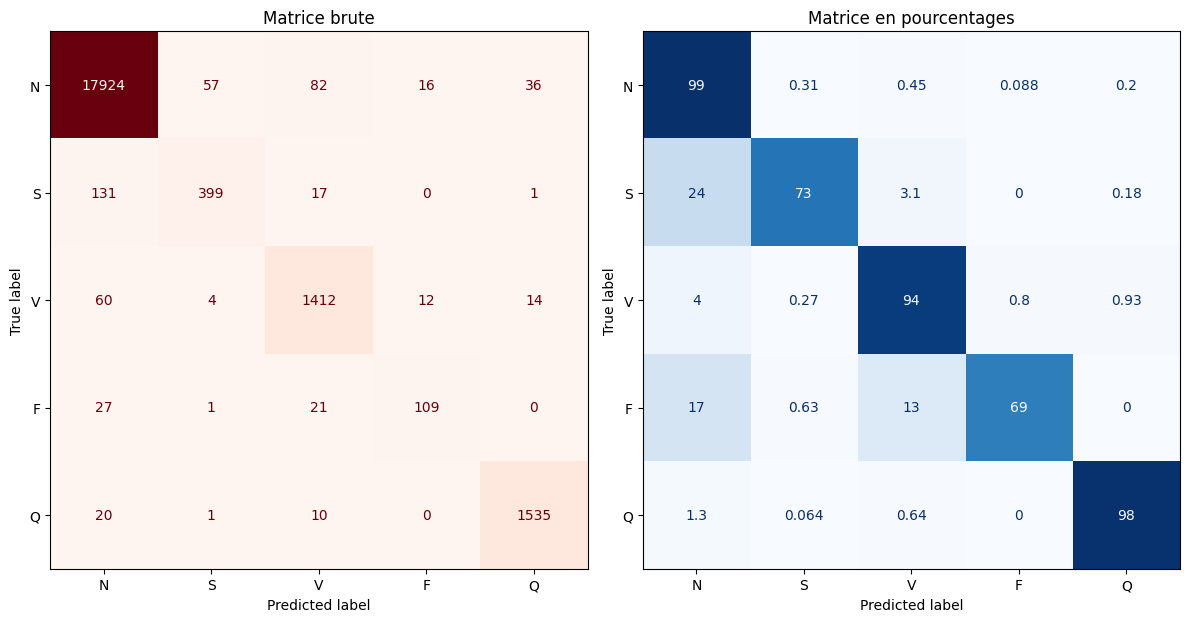

In [39]:
metrics_display(y_true, y_pred, predictions)

On observe que les résultats sont supérieurs à la baseline, notamment le recall qui est bien meilleur. Les classes S et F sont bien mieux classées.

On enregistre le modèle localement :

In [41]:
model.save('../models/inceptionv3_transfer_learning.h5')
model.save('../models/inceptionv3_transfer_learning_tf')
model.save('../models/inceptionv3_transfer_learning.keras')

INFO:tensorflow:Assets written to: inceptionv3_transfer_learning_tf/assets


INFO:tensorflow:Assets written to: inceptionv3_transfer_learning_tf/assets


### 3.4 Transfer learning avec EfficientNetV2

In [16]:
# Charger le modèle EfficientNetV2 pré-entraîné sans les couches supérieures
base_model = EfficientNetV2B3(weights='imagenet', include_top=False, input_shape=(100, 100, 3))

In [17]:
n = len(base_model.layers)
n

409

Le modèle contient 409 couches. Nous allons toutes les geler à l'exception des 20 dernières que nous allons ré-entraîner :

In [18]:
for layer in base_model.layers[:n-20]:
    layer.trainable = False

In [19]:
trainable_count = sum([layer.trainable for layer in base_model.layers])
print(f"Nombre de couches entraînables : {trainable_count}")

Nombre de couches entraînables : 20


Il y a bien 20 couches entraînables.

On ajoute au modèle de base une couche dense de classification à 1024 neurones et une couche dense de sortie à 5 neurones (une pour chaque classe) :

In [20]:
# Ajout des couches de classification
model = Sequential([base_model,
                    GlobalAveragePooling2D(),
                    Dense(1024, activation='relu'),
                    Dense(5, activation='softmax')
                   ])

In [21]:
# Compiler le modèle
model.compile(optimizer=Nadam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-b3 (Functio  (None, 4, 4, 1536)        12930622  
 nal)                                                            
                                                                 
 global_average_pooling2d (  (None, 1536)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1024)              1573888   
                                                                 
 dense_1 (Dense)             (None, 5)                 5125      
                                                                 
Total params: 14509635 (55.35 MB)
Trainable params: 2765807 (10.55 MB)
Non-trainable params: 11743828 (44.80 MB)
_________________________________________________________________


In [23]:
# Construction des callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001)

# Entraîner le modèle
history = model.fit(train_generator,
                    validation_data=test_generator,
                    callbacks=[early_stopping, reduce_lr],
                    epochs=10)

Epoch 1/10
2737/2737 [==============================] - 1087s 392ms/step - loss: 0.4155 - accuracy: 0.8840 - val_loss: 0.2598 - val_accuracy: 0.9274 - lr: 0.0010
Epoch 2/10
2737/2737 [==============================] - 1289s 471ms/step - loss: 0.3191 - accuracy: 0.9105 - val_loss: 0.2881 - val_accuracy: 0.9221 - lr: 0.0010
Epoch 3/10
2737/2737 [==============================] - 1790s 654ms/step - loss: 0.2881 - accuracy: 0.9194 - val_loss: 0.2476 - val_accuracy: 0.9340 - lr: 0.0010
Epoch 4/10
2737/2737 [==============================] - 1798s 657ms/step - loss: 0.2672 - accuracy: 0.9242 - val_loss: 0.2211 - val_accuracy: 0.9391 - lr: 0.0010
Epoch 5/10
2737/2737 [==============================] - 1789s 654ms/step - loss: 0.2515 - accuracy: 0.9275 - val_loss: 0.2245 - val_accuracy: 0.9384 - lr: 0.0010
Epoch 6/10
2737/2737 [==============================] - 1427s 521ms/step - loss: 0.2382 - accuracy: 0.9321 - val_loss: 0.1931 - val_accuracy: 0.9495 - lr: 0.0010
Epoch 7/10
2737/2737 [======

In [24]:
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)

685/685 [==============================] - 294s 425ms/step


In [25]:
# Obtenir les étiquettes réelles du générateur de test
y_true = test_generator.classes

accuracy = 0.9416145095710174   precision = 0.8774061707665712   recall=0.6408168424485494   f1 = 0.6825452723112602   ARI = 0.7740204362182196
AUC-ROC = 0.9565259335414315


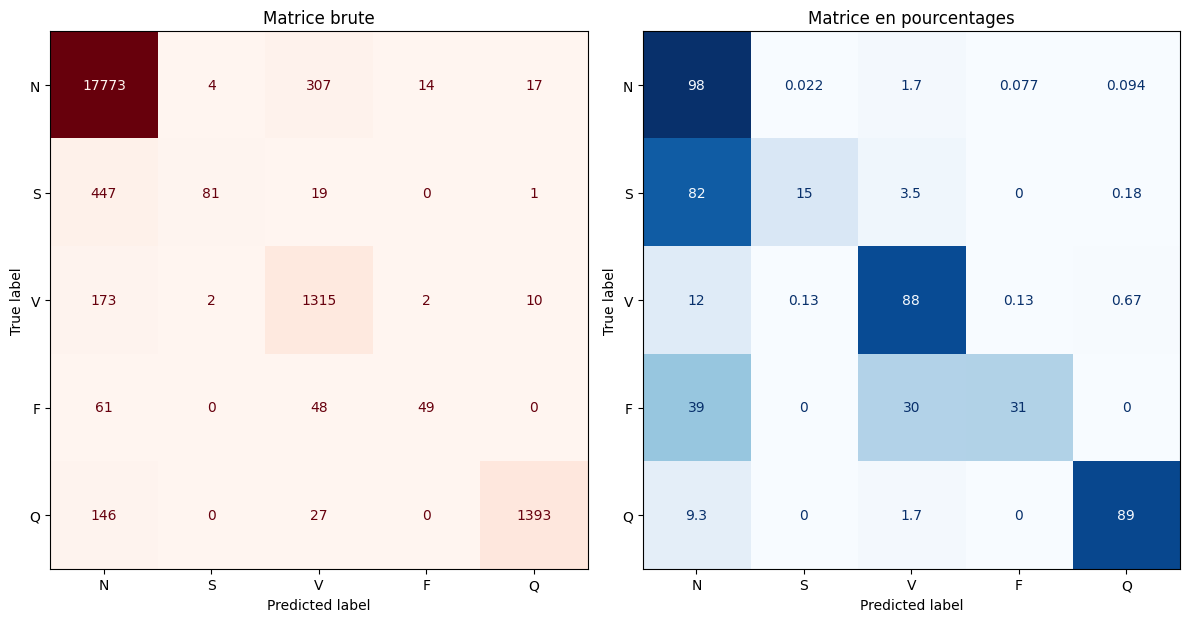

In [26]:
metrics_display(y_true, y_pred, predictions)

On enregistre le modèle localement puis dans Mlflow :

In [27]:
model.save('../models/efficientnetv2_transfer_learning.h5')
model.save('../models/efficientnetv2_transfer_learning_tf')
model.save('../models/efficientnetv2_transfer_learning.keras')

/home/chakir/Bureau/PROJETS/Projet7/env/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: efficientnetv2_transfer_learning_tf/assets


INFO:tensorflow:Assets written to: efficientnetv2_transfer_learning_tf/assets


## 4. LSTM et InceptionTime

### 4.1 Préparation des données

Commençons par redimensionner les données pour les adapter à un LSTM. Actuellement, chaque série temporelle a une longueur de 187. Nous allons découper chaque série en sous-séries de longueur 32 (sauf la dernière qui aura une longueur de 27).

In [50]:
# Longueur de la séquence (timesteps)
timesteps = 32

# Créer des sous-séquences
def create_subsequences(X, timesteps):
    timelist = range(0, 32*int(187/timesteps), timesteps)
    subsequences = []
    for i in timelist:
        subsequences.append(X[:, i:i+timesteps])
    subsequences = np.transpose(subsequences, (1, 2, 0))        
    return np.array(subsequences)

In [51]:
X_train_lstm = create_subsequences(X_train.values, timesteps)
X_test_lstm = create_subsequences(X_test.values, timesteps)

In [53]:
# Encodage One_hot des variables cibles
y_train_lstm = to_categorical(y_train)
y_test_lstm = to_categorical(y_test)

In [54]:
X_train_lstm.shape, y_train_lstm.shape

((87555, 32, 5), (87555, 5))

### 4.2 LSTM

In [55]:
# Ajout des couches de classification
model = Sequential([LSTM(50, activation='relu', input_shape=(timesteps, 5)),
                    Dense(512, activation='relu'),
                    Dense(5, activation='softmax')
                   ])

In [56]:
# Compiler le modèle
model.compile(optimizer=Nadam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [57]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                11200     
                                                                 
 dense_2 (Dense)             (None, 512)               26112     
                                                                 
 dense_3 (Dense)             (None, 5)                 2565      
                                                                 
Total params: 39877 (155.77 KB)
Trainable params: 39877 (155.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [58]:
# Construction des callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001)

# Entraîner le modèle
history = model.fit(X_train_lstm, y_train_lstm,
                    validation_data=(X_test_lstm, y_test_lstm),
                    callbacks=[early_stopping, reduce_lr],
                    epochs=10)

Epoch 1/10
2737/2737 [==============================] - 41s 14ms/step - loss: 0.3005 - accuracy: 0.9191 - val_loss: 0.2257 - val_accuracy: 0.9365 - lr: 0.0010
Epoch 2/10
2737/2737 [==============================] - 40s 15ms/step - loss: 0.1923 - accuracy: 0.9477 - val_loss: 0.1981 - val_accuracy: 0.9468 - lr: 0.0010
Epoch 3/10
2737/2737 [==============================] - 38s 14ms/step - loss: 0.1652 - accuracy: 0.9544 - val_loss: 0.1599 - val_accuracy: 0.9560 - lr: 0.0010
Epoch 4/10
2737/2737 [==============================] - 39s 14ms/step - loss: 0.1490 - accuracy: 0.9589 - val_loss: 0.1458 - val_accuracy: 0.9601 - lr: 0.0010
Epoch 5/10
2737/2737 [==============================] - 39s 14ms/step - loss: 0.1334 - accuracy: 0.9630 - val_loss: 0.1223 - val_accuracy: 0.9668 - lr: 0.0010
Epoch 6/10
2737/2737 [==============================] - 39s 14ms/step - loss: 0.1236 - accuracy: 0.9661 - val_loss: 0.1251 - val_accuracy: 0.9651 - lr: 0.0010
Epoch 7/10
2737/2737 [========================

In [59]:
predictions = model.predict(X_test_lstm)
y_pred = np.argmax(predictions, axis=1)

685/685 [==============================] - 4s 6ms/step


accuracy = 0.9676093014756271   precision = 0.9097655121944987   recall=0.79164679225016   f1 = 0.8309177944763949   ARI = 0.8858330684184192
AUC-ROC = 0.9831137905610614


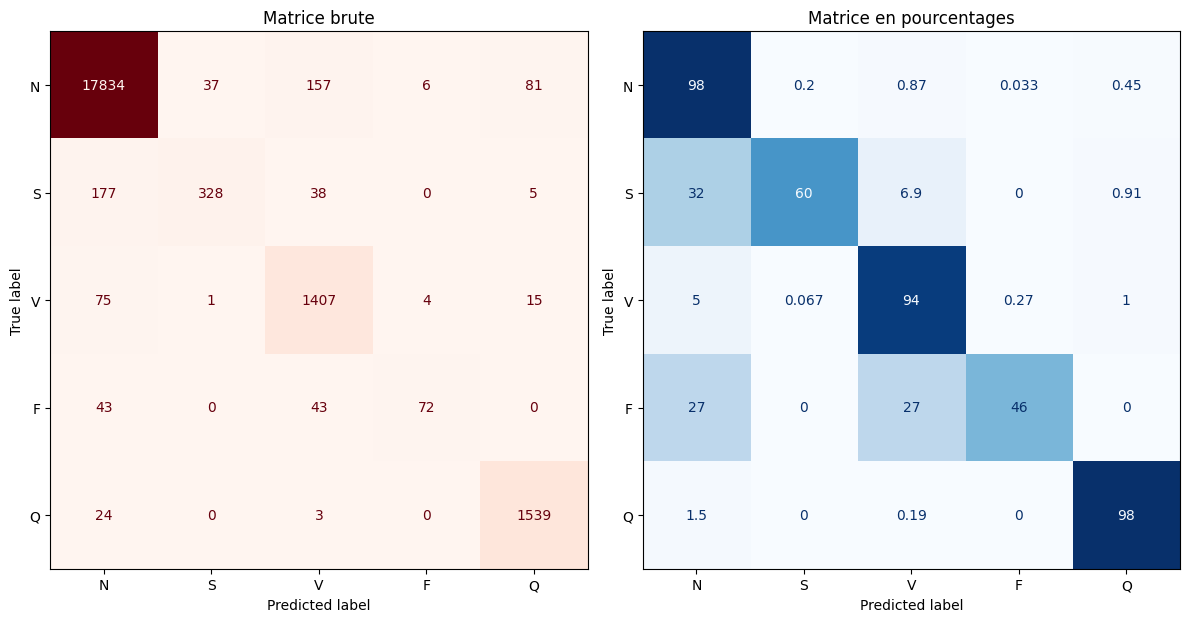

In [60]:
metrics_display(y_test, y_pred, predictions)

In [61]:
# Ajout des couches de classification
model = Sequential([LSTM(128, activation='relu', return_sequences=True, input_shape=(timesteps, 5)),
                    LSTM(128, activation='relu'),
                    Dense(1024, activation='relu'),
                    Dense(5, activation='softmax')
                   ])

In [62]:
# Compiler le modèle
model.compile(optimizer=Nadam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [63]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 32, 128)           68608     
                                                                 
 lstm_2 (LSTM)               (None, 128)               131584    
                                                                 
 dense_4 (Dense)             (None, 1024)              132096    
                                                                 
 dense_5 (Dense)             (None, 5)                 5125      
                                                                 
Total params: 337413 (1.29 MB)
Trainable params: 337413 (1.29 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [64]:
# Construction des callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001)

# Entraîner le modèle
history = model.fit(X_train_lstm, y_train_lstm,
                    validation_data=(X_test_lstm, y_test_lstm),
                    callbacks=[early_stopping, reduce_lr],
                    epochs=20)

Epoch 1/20
2737/2737 [==============================] - 162s 58ms/step - loss: 0.2721 - accuracy: 0.9281 - val_loss: 0.1798 - val_accuracy: 0.9507 - lr: 0.0010
Epoch 2/20
2737/2737 [==============================] - 176s 64ms/step - loss: 0.1623 - accuracy: 0.9555 - val_loss: 0.1584 - val_accuracy: 0.9583 - lr: 0.0010
Epoch 3/20
2737/2737 [==============================] - 172s 63ms/step - loss: 0.1332 - accuracy: 0.9637 - val_loss: 0.1214 - val_accuracy: 0.9660 - lr: 0.0010
Epoch 4/20
2737/2737 [==============================] - 176s 64ms/step - loss: 0.1159 - accuracy: 0.9673 - val_loss: 0.1202 - val_accuracy: 0.9649 - lr: 0.0010
Epoch 5/20
2737/2737 [==============================] - 176s 64ms/step - loss: 0.1049 - accuracy: 0.9707 - val_loss: 0.1072 - val_accuracy: 0.9698 - lr: 0.0010
Epoch 6/20
2737/2737 [==============================] - 173s 63ms/step - loss: 0.0966 - accuracy: 0.9727 - val_loss: 0.0983 - val_accuracy: 0.9723 - lr: 0.0010
Epoch 7/20
2737/2737 [==================

In [65]:
predictions = model.predict(X_test_lstm)
y_pred = np.argmax(predictions, axis=1)

685/685 [==============================] - 15s 21ms/step


accuracy = 0.9820914614646626   precision = 0.9535595945141058   recall=0.8518074685678897   f1 = 0.893305726296316   ARI = 0.9354684867238802
AUC-ROC = 0.9924947996303747


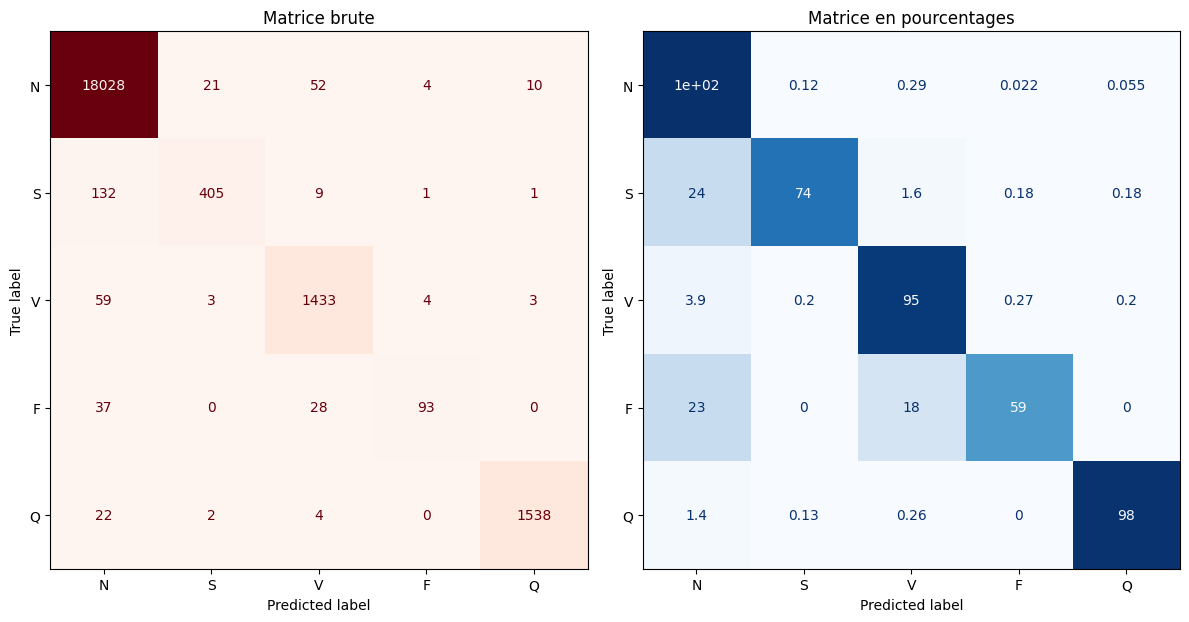

In [66]:
metrics_display(y_test, y_pred, predictions)

### 4.3 InceptionTime

In [67]:
from tensorflow.keras.layers import Conv1D, BatchNormalization, Activation, Concatenate, MaxPooling1D, Input, GlobalAveragePooling1D
from tensorflow.keras.models import Model

In [68]:
def inception_module(input_tensor, filters):
    # Branche 1 - Conv 1x1
    conv1 = Conv1D(filters=filters, kernel_size=1, padding='same')(input_tensor)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)

    # Branche 2 - Conv 3x3
    conv3 = Conv1D(filters=filters, kernel_size=3, padding='same')(input_tensor)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)

    # Branche 3 - Conv 5x5
    conv5 = Conv1D(filters=filters, kernel_size=5, padding='same')(input_tensor)
    conv5 = BatchNormalization()(conv5)
    conv5 = Activation('relu')(conv5)

    # Branche 4 - MaxPooling suivi d'une Conv 1x1
    pool = MaxPooling1D(pool_size=3, strides=1, padding='same')(input_tensor)
    pool = Conv1D(filters=filters, kernel_size=1, padding='same')(pool)
    pool = BatchNormalization()(pool)
    pool = Activation('relu')(pool)

    # Concatenation de toutes les branches
    output = Concatenate()([conv1, conv3, conv5, pool])
    
    return output

In [88]:
def build_inceptiontime_model(input_shape, num_classes):
    input_layer = Input(shape=input_shape)
    
    # Empiler plusieurs modules Inception
    x = inception_module(input_layer, filters=32)
    x = inception_module(x, filters=32)
    x = inception_module(x, filters=32)
    
    # Ajout des couches de classification
    x = GlobalAveragePooling1D()(x)
    x = Dense(1024, activation='relu')(x)
    output_layer = Dense(num_classes, activation='softmax')(x)
    
    # Construction du modèle complet
    model = Model(inputs=input_layer, outputs=output_layer)
    
    return model

In [89]:
input_shape = (32, 5)
num_classes = 5

model = build_inceptiontime_model(input_shape, num_classes)

In [90]:
# Compiler le modèle
model.compile(optimizer=Nadam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [91]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 32, 5)]              0         []                            
                                                                                                  
 max_pooling1d_9 (MaxPoolin  (None, 32, 5)                0         ['input_5[0][0]']             
 g1D)                                                                                             
                                                                                                  
 conv1d_36 (Conv1D)          (None, 32, 32)               192       ['input_5[0][0]']             
                                                                                                  
 conv1d_37 (Conv1D)          (None, 32, 32)               512       ['input_5[0][0]']       

In [92]:
# Construction des callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001)

# Entraîner le modèle
history = model.fit(X_train_lstm, y_train_lstm,
                    validation_data=(X_test_lstm, y_test_lstm),
                    callbacks=[early_stopping, reduce_lr],
                    epochs=30)

Epoch 1/30
2737/2737 [==============================] - 103s 34ms/step - loss: 0.1808 - accuracy: 0.9495 - val_loss: 0.1183 - val_accuracy: 0.9686 - lr: 0.0010
Epoch 2/30
2737/2737 [==============================] - 59s 22ms/step - loss: 0.1191 - accuracy: 0.9671 - val_loss: 0.1169 - val_accuracy: 0.9667 - lr: 0.0010
Epoch 3/30
2737/2737 [==============================] - 54s 20ms/step - loss: 0.0988 - accuracy: 0.9727 - val_loss: 0.0875 - val_accuracy: 0.9761 - lr: 0.0010
Epoch 4/30
2737/2737 [==============================] - 74s 27ms/step - loss: 0.0867 - accuracy: 0.9759 - val_loss: 0.0970 - val_accuracy: 0.9725 - lr: 0.0010
Epoch 5/30
2737/2737 [==============================] - 57s 21ms/step - loss: 0.0788 - accuracy: 0.9773 - val_loss: 0.0900 - val_accuracy: 0.9762 - lr: 0.0010
Epoch 6/30
2737/2737 [==============================] - 89s 32ms/step - loss: 0.0733 - accuracy: 0.9784 - val_loss: 0.0909 - val_accuracy: 0.9758 - lr: 0.0010
Epoch 7/30
2737/2737 [=======================

In [93]:
predictions = model.predict(X_test_lstm)
y_pred = np.argmax(predictions, axis=1)

685/685 [==============================] - 6s 8ms/step


accuracy = 0.9870254465713372   precision = 0.9367843895796681   recall=0.9084609124969016   f1 = 0.9218974197605796   ARI = 0.9548924545386742
AUC-ROC = 0.9942754968773372


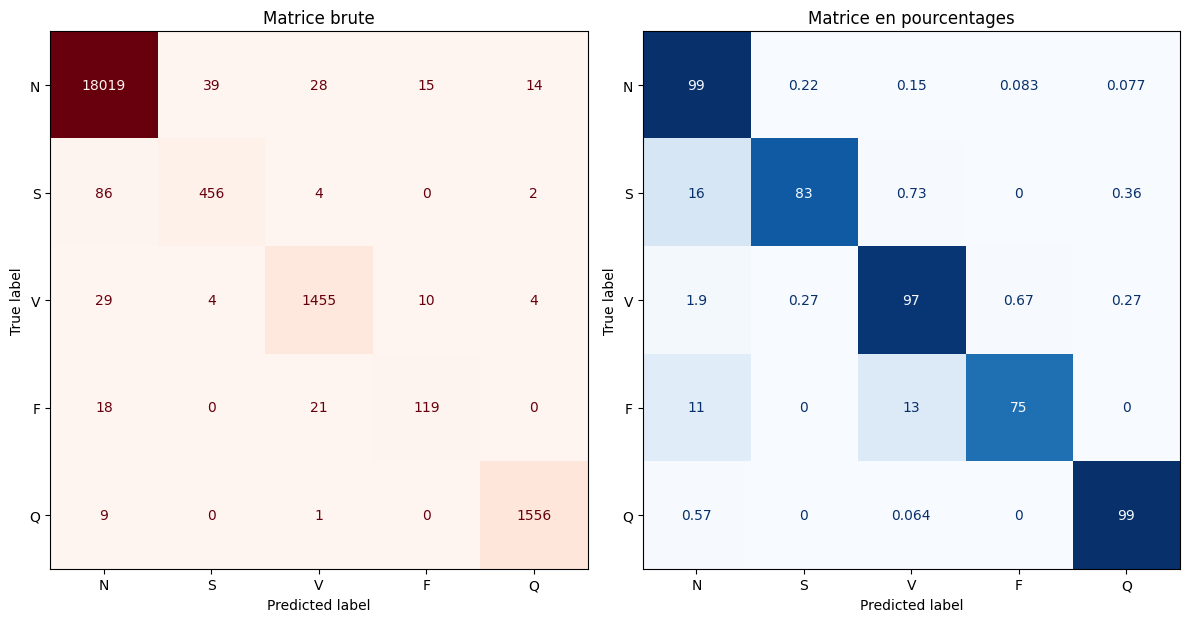

In [94]:
metrics_display(y_test, y_pred, predictions)

In [95]:
model.save('../models/inception_time.h5')
model.save('../models/inception_time_tf')
model.save('../models/inception_time.keras')

/home/chakir/Bureau/PROJETS/Projet7/env/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: ../models/inception_time_tf/assets


INFO:tensorflow:Assets written to: ../models/inception_time_tf/assets


### 4.4 InceptionTime avec LSTM

In [80]:
def build_inception_lstm_model(input_shape, num_classes):
    input_layer = Input(shape=input_shape)
    
    # Empilement de modules Inception
    x = inception_module(input_layer, filters=32)
    x = inception_module(x, filters=32)
    x = inception_module(x, filters=32)
    
    # Ajout de deux couches LSTM
    x = LSTM(128, return_sequences=True)(x)
    x = LSTM(64)(x)  
    
    # Ajout des couches de classification
    x = Dense(1024, activation='relu')(x)
    output_layer = Dense(num_classes, activation='softmax')(x)
    
    # Construction du modèle complet
    model = Model(inputs=input_layer, outputs=output_layer)
    
    return model

In [81]:
model = build_inception_lstm_model(input_shape, num_classes)

In [82]:
# Compiler le modèle
model.compile(optimizer=Nadam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [83]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 32, 5)]              0         []                            
                                                                                                  
 max_pooling1d_6 (MaxPoolin  (None, 32, 5)                0         ['input_4[0][0]']             
 g1D)                                                                                             
                                                                                                  
 conv1d_24 (Conv1D)          (None, 32, 32)               192       ['input_4[0][0]']             
                                                                                                  
 conv1d_25 (Conv1D)          (None, 32, 32)               512       ['input_4[0][0]']       

In [84]:
# Construction des callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001)

# Entraîner le modèle
history = model.fit(X_train_lstm, y_train_lstm,
                    validation_data=(X_test_lstm, y_test_lstm),
                    callbacks=[early_stopping, reduce_lr],
                    epochs=30)

Epoch 1/30
2737/2737 [==============================] - 243s 83ms/step - loss: 0.2002 - accuracy: 0.9449 - val_loss: 0.1540 - val_accuracy: 0.9588 - lr: 0.0010
Epoch 2/30
2737/2737 [==============================] - 229s 84ms/step - loss: 0.1284 - accuracy: 0.9646 - val_loss: 0.1131 - val_accuracy: 0.9688 - lr: 0.0010
Epoch 3/30
2737/2737 [==============================] - 224s 82ms/step - loss: 0.1066 - accuracy: 0.9702 - val_loss: 0.0913 - val_accuracy: 0.9756 - lr: 0.0010
Epoch 4/30
2737/2737 [==============================] - 224s 82ms/step - loss: 0.0940 - accuracy: 0.9727 - val_loss: 0.0959 - val_accuracy: 0.9720 - lr: 0.0010
Epoch 5/30
2737/2737 [==============================] - 225s 82ms/step - loss: 0.0859 - accuracy: 0.9749 - val_loss: 0.0827 - val_accuracy: 0.9764 - lr: 0.0010
Epoch 6/30
2737/2737 [==============================] - 223s 81ms/step - loss: 0.0781 - accuracy: 0.9770 - val_loss: 0.0826 - val_accuracy: 0.9776 - lr: 0.0010
Epoch 7/30
2737/2737 [==================

In [85]:
predictions = model.predict(X_test_lstm)
y_pred = np.argmax(predictions, axis=1)

685/685 [==============================] - 17s 23ms/step


accuracy = 0.9840559184978757   precision = 0.9441437651743643   recall=0.8742878597656139   f1 = 0.9047522637086016   ARI = 0.9444014138785145
AUC-ROC = 0.9944581656688174


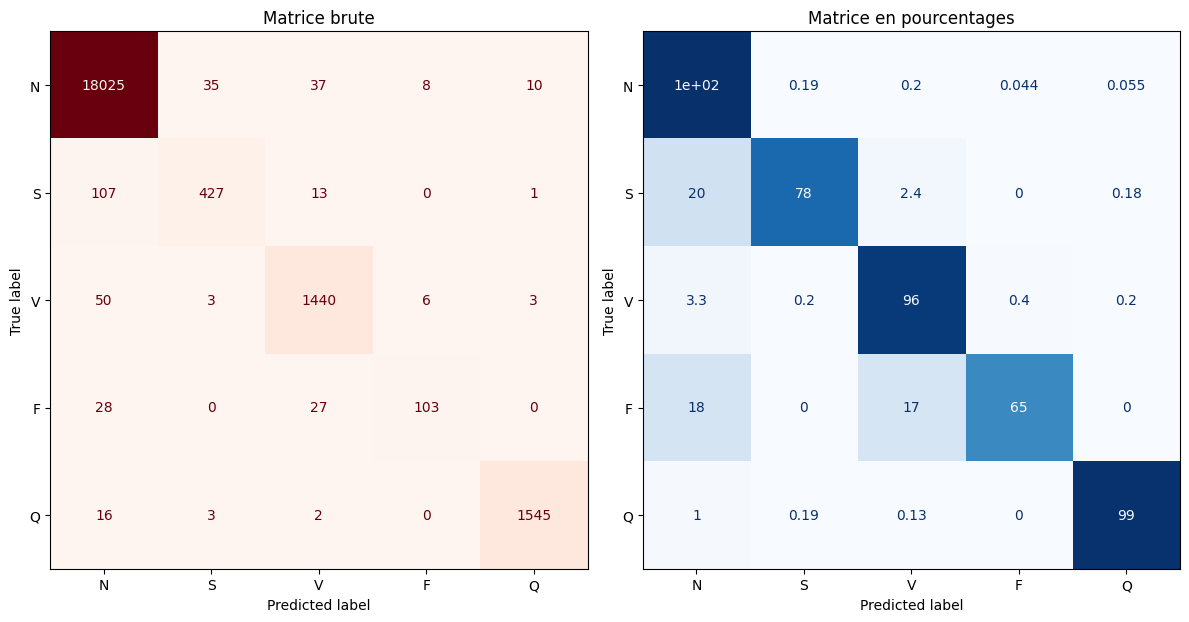

In [86]:
metrics_display(y_test, y_pred, predictions)

In [87]:
model.save('../models/inception_time_lstm.h5')
model.save('../models/inception_time_lstm_tf')
model.save('../models/inception_time_lstm.keras')

/home/chakir/Bureau/PROJETS/Projet7/env/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: ../models/inception_time_lstm_tf/assets


INFO:tensorflow:Assets written to: ../models/inception_time_lstm_tf/assets
